# DeepHit for Single Event

In this notebook we show an example of how we can fit a [DeepHit](http://medianetlab.ee.ucla.edu/papers/AAAI_2018_DeepHit) model when we only have *one* event type.

If you are interested in **competing risks**, see [this notebook](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/deephit_competing_risks.ipynb) instead.

For a more verbose introduction to `pycox` see [this notebook](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/01_introduction.ipynb).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

import torch # For building the networks 
import torchtuples as tt # Some useful functions

from pycox.datasets import metabric, support
from pycox.models import DeepHitSingle, LogisticHazard, PMF
from pycox.preprocessing.feature_transforms import OrderedCategoricalLong

from pycox.evaluation import EvalSurv

In [2]:
## Uncomment to install `sklearn-pandas`
# ! pip install sklearn-pandas

In [3]:
np.random.seed(1234)
_ = torch.manual_seed(123)

## Dataset

We load the METABRIC data set as a pandas DataFrame and split the data in in train, test and validation.

The `duration` column gives the observed times and the `event` column contains indicators of whether the observation is an event (1) or a censored observation (0).

In [4]:
df_full = support.read_df()
df_test = df_full.sample(frac=0.2)
df_train = df_full.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [5]:
df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,duration,event
0,82.709961,1.0,2.0,1.0,0.0,0.0,0.0,160.0,55.0,16.0,38.195309,142.0,19.000000,1.099854,30.0,1
3,53.075989,1.0,4.0,3.0,0.0,0.0,0.0,55.0,100.0,18.0,36.000000,135.0,8.699219,0.799927,892.0,0
4,71.794983,0.0,1.0,1.0,0.0,0.0,0.0,65.0,135.0,40.0,38.593750,146.0,0.099991,0.399963,7.0,1
7,71.457947,1.0,4.0,1.0,0.0,0.0,2.0,68.0,102.0,24.0,35.500000,134.0,9.199219,1.399902,1530.0,0
9,67.462952,1.0,4.0,1.0,0.0,0.0,1.0,73.0,75.0,28.0,36.000000,140.0,15.798828,0.699951,70.0,1


## Feature transforms

The METABRIC dataset has  9 covariates: `x0, ..., x8`.
We will standardize the 5 numerical covariates, and leave the binary covariates as is.
Note that PyTorch require variables of type `'float32'`.

We like using the `sklearn_pandas.DataFrameMapper` to make feature mappers.

In [6]:
cols_standardize =  ['x0', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13']
cols_leave = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [7]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

## Label transforms

The survival methods require individual label transforms, so we have included a proposed `label_transform` for each method.
In this case `label_transform` is just a shorthand for the class `pycox.preprocessing.label_transforms.LabTransDiscreteTime`.

DeepHit is a discrete-time method, meaning it requires discretization of the event times to be applied to continuous-time data.
We let `num_durations` define the size of this (equidistant) discretization grid, meaning our network will have `num_durations` output nodes.

In [8]:
num_durations = 20
scheme = 'quantiles'
labtrans = DeepHitSingle.label_transform(num_durations, scheme)

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [9]:
type(labtrans)

pycox.preprocessing.label_transforms.LabTransDiscreteTime

## Neural net

We make a neural net with `torch`.
For simple network structures, we can use the `MLPVanilla` provided by `torchtuples`.
For building more advanced network architectures, see for example [the tutorials by PyTroch](https://pytorch.org/tutorials/).

The following net is an MLP with two hidden layers (with 32 nodes each), ReLU activations, and `num_nodes` output nodes.
We also have batch normalization and dropout between the layers.

In [10]:
# in_features = x_train.shape[1]
# num_nodes = [32, 32]
# out_features = labtrans.out_features
# batch_norm = True
# dropout = 0.1

# net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

If you instead want to build this network with `torch` you can uncomment the following code.
It is essentially equivalent to the `MLPVanilla`, but without the `torch.nn.init.kaiming_normal_` weight initialization.

In [11]:
import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

class TransformerModel(nn.Module):

    def __init__(self, in_features: int, seq_len:int,  d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Linear(in_features, d_model)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, 1)
        self.seq_len = seq_len

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)
    
    def _forward(self, x: Tensor) -> Tensor:
        x = torch.unsqueeze(x, 0).repeat(self.seq_len, 1, 1) # [seq_len, batch_size, in_features]
        seq_mask = generate_square_subsequent_mask(self.seq_len).to(x.device)
        x = self.encoder(x) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        encoded = self.transformer_encoder(x, seq_mask) # [seq_len, batch_size, d_model]
        decoded = self.decoder(encoded) # [seq_len, batch_size, 1]
        phi = decoded.squeeze(2).t()
        
        return phi, decoded
    
    def forward(self, x: Tensor) -> Tensor:
        phi, decoded = self._forward(x)
        return phi

def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

In [12]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [13]:
in_features = x_train.shape[1]
out_features = labtrans.out_features
emsize = 200  # embedding dimension
d_hid = 200  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # number of heads in nn.MultiheadAttention
dropout = 0.2  # dropout probability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = TransformerModel(in_features, num_durations, emsize, nhead, d_hid, nlayers, dropout).to(device)

## Training the model

To train the model we need to define an optimizer. You can choose any `torch.optim` optimizer, but here we instead use one from `tt.optim` as it has some added functionality.
We use the `Adam` optimizer, but instead of choosing a learning rate, we will use the scheme proposed by [Smith 2017](https://arxiv.org/pdf/1506.01186.pdf) to find a suitable learning rate with `model.lr_finder`. See [this post](https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for an explanation.

We also set `duration_index` which connects the output nodes of the network the the discretization times. This is only useful for prediction and does not affect the training procedure.

DeepHit has a loss that is a combination of a negative log-likelihood and a ranking loss. `alpha` is a parameter that controls the linear combination between the two, and `sigma` is a parameter used by the ranking loss. `alpha = 1` give a loss only containing the negative log-likelihood and `alpha = 0` give a pure ranking loss. Note that this is different than the original paper.

In [14]:
model = DeepHitSingle(net, tt.optim.Adam, alpha=0.2, sigma=0.1, duration_index=labtrans.cuts)
#model = LogisticHazard(net, tt.optim.Adam, duration_index=labtrans.cuts)
#model = PMF(net, tt.optim.Adam, duration_index=labtrans.cuts)

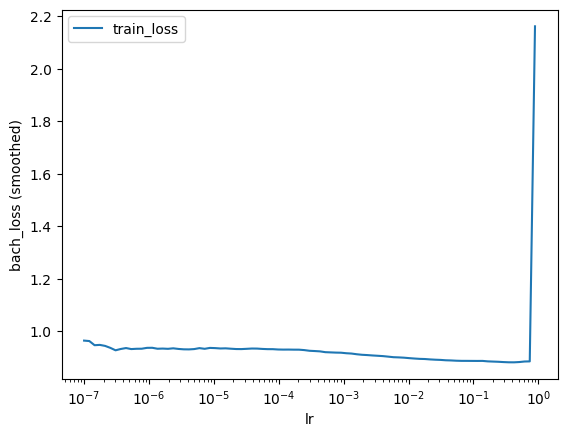

In [15]:
batch_size = 256
lr_finder = model.lr_finder(x_train, y_train, batch_size, tolerance=3)
_ = lr_finder.plot()

In [16]:
lr_finder.get_best_lr()

0.04229242874389523

Often, this learning rate is a little high, so we instead set it manually to 0.01

In [17]:
model.optimizer.set_lr(0.0005)

We include the `EarlyStopping` callback to stop training when the validation loss stops improving. After training, this callback will also load the best performing model in terms of validation loss.

In [18]:
epochs = 500
callbacks = [tt.callbacks.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 0.8651,	val_loss: 0.8446
1:	[0s / 0s],		train_loss: 0.8443,	val_loss: 0.8416
2:	[0s / 1s],		train_loss: 0.8424,	val_loss: 0.8438
3:	[0s / 1s],		train_loss: 0.8392,	val_loss: 0.8403
4:	[0s / 1s],		train_loss: 0.8392,	val_loss: 0.8398
5:	[0s / 2s],		train_loss: 0.8339,	val_loss: 0.8336
6:	[0s / 2s],		train_loss: 0.8339,	val_loss: 0.8322
7:	[0s / 3s],		train_loss: 0.8288,	val_loss: 0.8301
8:	[0s / 3s],		train_loss: 0.8237,	val_loss: 0.8292
9:	[0s / 4s],		train_loss: 0.8247,	val_loss: 0.8310
10:	[0s / 4s],		train_loss: 0.8287,	val_loss: 0.8303
11:	[0s / 4s],		train_loss: 0.8215,	val_loss: 0.8273
12:	[0s / 5s],		train_loss: 0.8227,	val_loss: 0.8285
13:	[0s / 5s],		train_loss: 0.8227,	val_loss: 0.8267
14:	[0s / 5s],		train_loss: 0.8232,	val_loss: 0.8248
15:	[0s / 6s],		train_loss: 0.8210,	val_loss: 0.8263
16:	[0s / 6s],		train_loss: 0.8201,	val_loss: 0.8264
17:	[0s / 7s],		train_loss: 0.8185,	val_loss: 0.8327
18:	[0s / 7s],		train_loss: 0.8230,	val_loss: 0.8296
19:

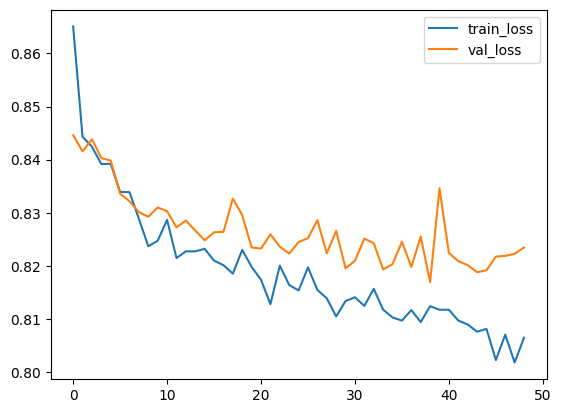

In [19]:
_ = log.plot()

## Prediction

For evaluation we first need to obtain survival estimates for the test set.
This can be done with `model.predict_surv` which returns an array of survival estimates, or with `model.predict_surv_df` which returns the survival estimates as a dataframe.

In [20]:
surv = model.predict_surv_df(x_test)

We can plot the survival estimates for the first 5 individuals.
Note that the time scale is correct because we have set `model.duration_index` to be the grid points.
We have, however, only defined the survival estimates at the 10 times in our discretization grid, so, the survival estimates is a step function

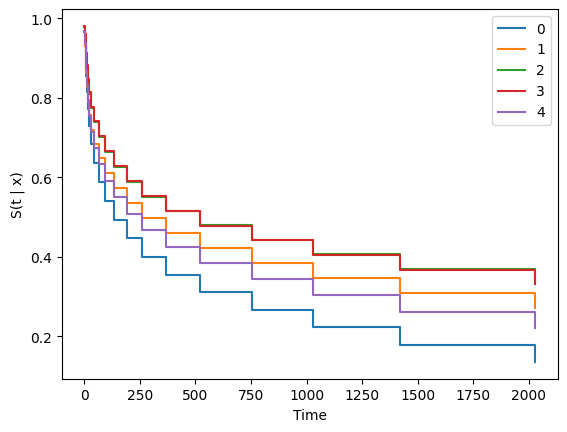

In [21]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

It is, therefore, often beneficial to interpolate the survival estimates, see [this paper](https://arxiv.org/abs/1910.06724) for a discussion.
Linear interpolation (constant density interpolation) can be performed with the `interpolate` method. We also need to choose how many points we want to replace each grid point with. Her we will use 10.

In [37]:
surv = model.interpolate(10).predict_surv_df(x_test)

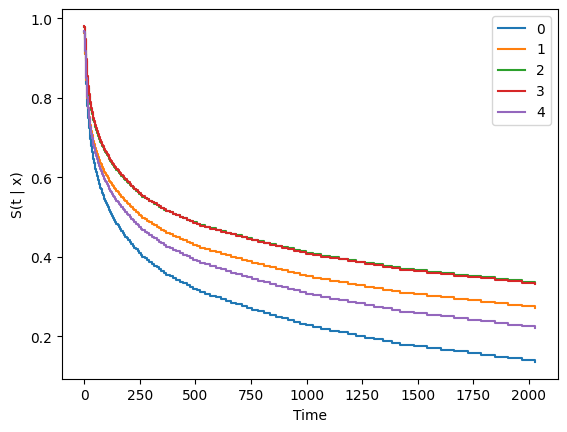

In [38]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

## Evaluation

The `EvalSurv` class contains some useful evaluation criteria for time-to-event prediction.
We set `censor_surv = 'km'` to state that we want to use Kaplan-Meier for estimating the censoring distribution.


In [39]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

C:\Users\youhs\AppData\Roaming\Python\Python39\site-packages\pycox\evaluation\eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


#### Concordance

We start with the event-time concordance by [Antolini et al. 2005](https://onlinelibrary.wiley.com/doi/10.1002/sim.2427).

In [40]:
ev.concordance_td('antolini')

0.6537983695246569

#### Brier Score

We can plot the the [IPCW Brier score](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5) for a given set of times.
Here we just use 100 time-points between the min and max duration in the test set.
Note that the score becomes unstable for the highest times. It is therefore common to disregard the rightmost part of the graph.

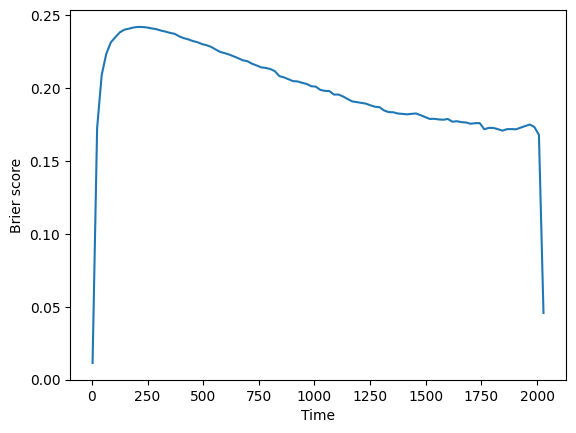

In [41]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

#### Negative binomial log-likelihood

In a similar manner, we can plot the the [IPCW negative binomial log-likelihood](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5).

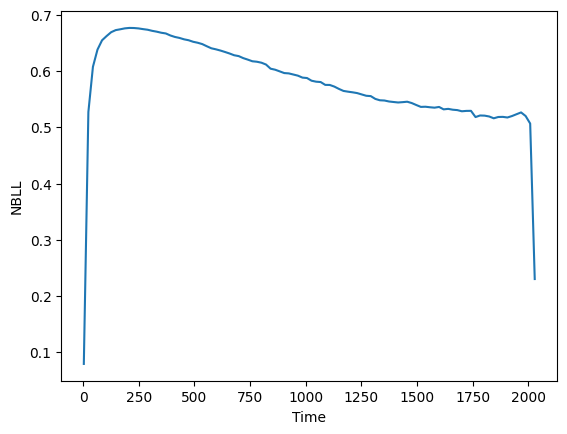

In [42]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

#### Integrated scores

The two time-dependent scores above can be integrated over time to produce a single score [Graf et al. 1999](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5). In practice this is done by numerical integration over a defined `time_grid`.

In [43]:
ev.integrated_brier_score(time_grid) 

0.20091133326837535

In [44]:
ev.integrated_nbll(time_grid) 

0.5859453190492727

In [45]:
labtrans.cuts[-2:]

array([1422., 2029.], dtype=float32)

### Trucated time-dependent C-index

In [46]:
horizons = [0.25, 0.5, 0.75] # truncated time horizons 25%, 50%, 75%
times = np.quantile(df_full.duration[df_full.event==1], horizons).tolist()
times

[14.0, 57.0, 250.25]

### Inference

In [47]:
surv_tr = surv.T # (samples, seq_len)

row = surv_tr.iloc[0]
ixs = [abs(row.index - t).argmin() for t in times]

print(row.index[ixs])

Float64Index([13.8, 56.0, 246.8], dtype='float64')


In [48]:
out_survival = surv_tr.loc[:, row.index[ixs]]
out_risk = 1.0 - out_survival

# pd -> numpy
out_survival = np.array(out_survival)
out_risk      = np.array(out_risk)

In [49]:
t_train, e_train = get_target(df_train)
t_test, e_test = get_target(df_test)
t_val, e_val = get_target(df_val)

In [50]:
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc

In [51]:
cis = []
brs = []

et_train = np.array([(e_train[i], t_train[i]) for i in range(len(e_train))],
                 dtype = [('e', bool), ('t', float)])
et_test = np.array([(e_test[i], t_test[i]) for i in range(len(e_test))],
                 dtype = [('e', bool), ('t', float)])
et_val = np.array([(e_val[i], t_val[i]) for i in range(len(e_val))],
                 dtype = [('e', bool), ('t', float)])

for i, _ in enumerate(times):
    cis.append(concordance_index_ipcw(et_train, et_test, out_risk[:, i], times[i])[0])
brs.append(brier_score(et_train, et_test, out_survival, times)[1])
roc_auc = []
for i, _ in enumerate(times):
    roc_auc.append(cumulative_dynamic_auc(et_train, et_test, out_risk[:, i], times[i])[0].item())
for horizon in enumerate(horizons):
    print(f"For {horizon[1]} quantile,")
    print("TD Concordance Index:", cis[horizon[0]])
    print("Brier Score:", brs[0][horizon[0]])
    print("ROC AUC ", roc_auc[horizon[0]], "\n")

For 0.25 quantile,
TD Concordance Index: 0.6774505461737144
Brier Score: 0.13626517464472374
ROC AUC  0.6913319671200011 

For 0.5 quantile,
TD Concordance Index: 0.6104357984375846
Brier Score: 0.22046446634220404
ROC AUC  0.6365959999662016 

For 0.75 quantile,
TD Concordance Index: 0.5796188972104543
Brier Score: 0.24154828192482533
ROC AUC  0.6423577159372882 



In [52]:
import pandas as pd

<Axes: >

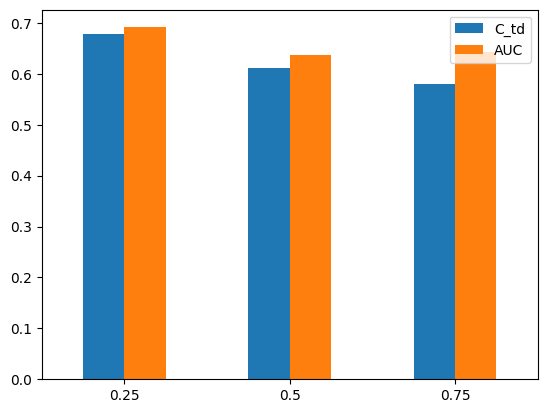

In [53]:
pd.DataFrame({'C_td': cis, 'AUC': roc_auc}, index=horizons).plot(kind='bar', rot=0)